In [1]:
import pyhdfs
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### 包成function

In [283]:
'''
讀取本地CSV檔
'''
def local_csv(df):
    # 將date欄位轉 str，並將/替換-，統一時間格式
    df['Date'] = df['Date'].astype(str).str.replace("/","-")
    # 判斷是否需進行民國轉西元
    len_date = len(df['Date'].values[0].split("-")[0])
    if len_date==4:
        pass
    else:
        df['Date'] = df['Date'].apply(lambda data: str(int(data[0:3])+1911)+season(data[3:]))
    return df

In [231]:
'''
比較當日收盤價與3日移動平均線
當日收盤價 > 3日移動平均線 --> 買進
當日收盤價 < 3日移動平均線 --> 賣出

固定區間內的收益
'''

def buy_fun(df_new):
    buy=[]
    sell=[]
    count=-1
    for i in range(1,len(df_new)+1):
        # 當日收盤價大於3日MA。則買進(buy放收盤價,sell放nan)並計1
        if df_new['Close'][i]>df_new['3D'][i]:
            sell.append(np.nan)
            buy.append(df_new['Close'][i])
            count = 1
        # 當日收盤價小於3日MA，若之前有買進，則賣出(buy放nan,sell放收盤價)。並計0   
        elif df_new['Close'][i]<df_new['3D'][i]:
            buy.append(np.nan)
            if count ==1:
                sell.append(df_new['Close'][i])
                count = 0
            else:
                sell.append(np.nan)
        # 當日收盤價等於3日MA，啥都不做
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    df_new['buy'] = buy
    df_new['sell'] = sell
    
    #print(buy)
    #print(sell)
    
    # 當日收盤價*剩餘股數
    count_buy = len(np.array(buy)[~np.isnan(np.array(buy))])
    count_sell = len(np.array(sell)[~np.isnan(np.array(sell))])
    re = df_new['Close'][len(df_new)]*(count_buy-count_sell)
    #print(count_buy,count_sell,re)
    
    # 賣出總額 - 買進總額 - 當日收盤價*剩餘股數
    buy_total = np.nansum(np.array(buy))
    sell_total = np.nansum(np.array(sell))
    get_money = sell_total-buy_total+re
    #print(buy_total,sell_total,re,get_money)
    
    return get_money

In [342]:
'''
total 欄位為今日購買後，n天後賣出的收(損)益
'''
def get_date(df):
    df_new_1=pd.DataFrame()
    df_new_1['Date'] = df['Date']
    df_new_1['Close'] = df['Close']
    df_new_1['3D']=df_new_1.rolling(3,min_periods=1).mean()
    df_new_1.index = df_new_1.index+1

    #滾動窗大小 window_size (可視為幾日後賣出的策略)
    window_size = 3
    total_list=[]
    for i in range(len(df_new_1)):
        df_new_1_test = df_new_1.iloc[i:i+window_size].reset_index()
        df_new_1_test.index = df_new_1_test.index+1
        total_list.append(buy_fun(df_new_1_test))

    df_new_1['total'] = total_list
    return df_new_1

In [280]:
#df = pd.read_csv('1101_selected_stock.csv')
df = pd.read_csv('2330.TW.csv')
df_get_date = local_csv(df)
df_csv = get_date(df_get_date)
df_csv.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5191/5191 [00:05<00:00, 905.26it/s]


,Date,Close,3D,total
1,2000-1-4,69.649002,69.649002,-1.565102
2,2000-1-5,71.214104,70.431553,-1.565102
3,2000-1-6,69.649002,70.170703,0.000000
4,2000-1-7,67.692497,69.518534,-1.173897
5,2000-1-10,70.040199,69.127233,-1.173897


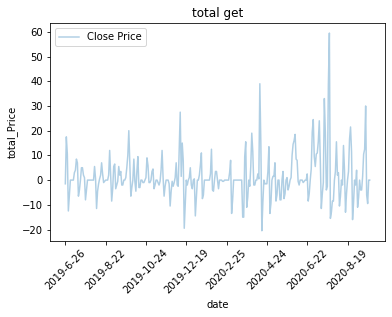

In [282]:
import matplotlib.ticker as ticker

# 選擇日期
date=df_csv.set_index(['Date'])['total']['2019-6-26':]

# x軸間隔
tick_spacing = 40
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#視覺化 buy and sell 
plt.plot(date, label='Close Price', alpha=0.35)
plt.title('total get')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total_Price')
plt.legend(loc='upper left')
plt.show()

In [254]:
#滾動窗大小 window_size
window_size = 20

# index控制時間開始位置
i = 5129
df_new_1_test_1 = df_new_1.iloc[i:i+window_size].reset_index()
df_new_1_test_1.index = df_new_1_test_1.index+1
df_new_1_test_1['total'] = buy_fun(df_new_1_test_1)
display(df_new_1_test_1)

,index,Date,Close,3D,total,buy,sell
1,5130,2020-6-23,315.0,313.833333,536.0,315.0,NaN
2,5131,2020-6-24,317.5,314.833333,536.0,317.5,NaN
3,5132,2020-6-29,312.0,314.833333,536.0,NaN,312.0
4,5133,2020-6-30,313.0,314.166667,536.0,NaN,NaN
5,5134,2020-7-1,317.5,314.166667,536.0,317.5,NaN
6,5135,2020-7-2,322.0,317.500000,536.0,322.0,NaN
7,5136,2020-7-3,329.5,323.000000,536.0,329.5,NaN
8,5137,2020-7-6,338.0,329.833333,536.0,338.0,NaN
9,5138,2020-7-7,338.5,335.333333,536.0,338.5,NaN
10,5139,2020-7-8,341.0,339.166667,536.0,341.0,NaN


### hdfs

In [348]:
# # 連接 hdfs
# client = pyhdfs.HdfsClient(hosts="10.120.26.200,50070",user_name="spark")
# client

# # 取得 hdfs 數量
# hdfs_list = client.listdir("/user/spark/stock/FC/data")
# len(hdfs_list)

# # 取得 csv資料
# hdfs_file =  client.open("/user/spark/stock/FC/data/1213.TW.csv")
# df_copy = pd.read_csv(hdfs_file)
# df_copy 

### 合併

In [376]:
import os

file_dir = 'total_company/'
for root, dirs, files in os.walk(file_dir): 
    print(files)


['1213.TW.csv', '1231.TW.csv', '1319.TW.csv', '2330.TW.csv']


In [379]:
# '''
# 要用再取消註解
# 合併各公司所有total欄位
# '''

# from functools import reduce
# import os

# file_dir = 'data/'
# for root, dirs, files in os.walk(file_dir): 

#     df_list=[]
#     for i in tqdm(files):
#         df = pd.read_csv('data/'+i)
#         df_get_date = local_csv(df)
#         df_csv = get_date(df_get_date)
#         df_concat = df_csv.drop(columns=['Close','3D'])
#         df_concat.columns = ['Date',i.split('.')[0]]
#         df_list.append(df_concat)
    
# df_combine = reduce(lambda df1,df2: pd.merge(df1,df2,on='Date',how="outer"), df_list)

# print(df_combine)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [56:09<00:00,  3.86s/it]


            Date      1101  1101B    1102     1103     1104  1108    1109  \
0     2000-01-04 -0.790199    NaN  0.1156  0.33597  0.07775   0.0  0.3406   
1     2000-01-05 -0.790199    NaN  0.1156  0.50397  0.03887   0.0  0.4542   
2     2000-01-06  0.000000    NaN  0.1544  0.50396 -0.01944   0.0 -0.2838   
3     2000-01-07 -0.526800    NaN -1.0798 -0.54596  0.00000   0.0 -0.1703   
4     2000-01-10 -0.526800    NaN -0.5785 -0.37797  0.03887   0.0 -0.2271   
...          ...       ...    ...     ...      ...      ...   ...     ...   
5383  2020-06-25       NaN    NaN     NaN      NaN      NaN   NaN     NaN   
5384  2020-06-26       NaN    NaN     NaN      NaN      NaN   NaN     NaN   
5385  2020-09-16       NaN    NaN     NaN      NaN      NaN   NaN     NaN   
5386  2020-09-17       NaN    NaN     NaN      NaN      NaN   NaN     NaN   
5387  2020-09-18       NaN    NaN     NaN      NaN      NaN   NaN     NaN   

         1110  1201  ...     9940      9941  9941A  9942  9943  9944     99

In [380]:
# 要用再取消註解
# df_combine.to_csv('company_combine.csv',encoding='utf-8')

### 圖

In [384]:
df_plt = df_combine.copy()
df_plt.head()

,Date,1101,1101B,1102,1103,1104,1108,1109,1110,1201,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
0,2000-01-04,-0.790199,NaN,0.1156,0.33597,0.07775,0.0,0.3406,0.00000,0.60,...,0.58874,0.000000,NaN,NaN,NaN,NaN,0.32801,NaN,NaN,NaN
1,2000-01-05,-0.790199,NaN,0.1156,0.50397,0.03887,0.0,0.4542,0.00000,1.90,...,1.40998,1.093599,NaN,NaN,NaN,NaN,0.32801,NaN,NaN,NaN
2,2000-01-06,0.000000,NaN,0.1544,0.50396,-0.01944,0.0,-0.2838,-0.27198,1.95,...,0.17812,2.187201,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN
3,2000-01-07,-0.526800,NaN,-1.0798,-0.54596,0.00000,0.0,-0.1703,-0.13599,2.05,...,-0.00533,-1.562201,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN
4,2000-01-10,-0.526800,NaN,-0.5785,-0.37797,0.03887,0.0,-0.2271,0.00000,0.70,...,0.05546,-1.054501,NaN,NaN,NaN,NaN,-0.06560,NaN,NaN,NaN


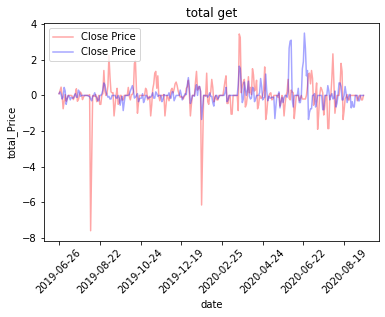

In [395]:
import matplotlib.ticker as ticker

# 選擇日期
date1 = df_plt.set_index(['Date'])['1101']['2019-06-26':]
date2 = df_plt.set_index(['Date'])['2332']['2019-06-26':]
# x軸間隔
tick_spacing = 40
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#視覺化 buy and sell 
plt.plot(date1, label='Close Price', alpha=0.35,color='red')
plt.plot(date2, label='Close Price', alpha=0.35,color='blue')
plt.title('total get')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total_Price')
plt.legend(loc='upper left')
plt.show()